In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from datetime import datetime

In [7]:
customers = pd.read_csv('onlineshop_customers.csv', parse_dates = ['created_at'])
orders = pd.read_csv('onlineshop_orders.csv', parse_dates = ['created_at', 'closed_at', 'cancelled_at'])
orders_items = pd.read_csv('onlineshop_orders_items.csv')
products = pd.read_csv('onlineshop_products.csv', parse_dates = ['created_at','published_at'])
traffic = pd.read_csv('onlineshop_traffic.csv', parse_dates = ['date_day'])
transactions = pd.read_csv('onlineshop_transactions.csv', parse_dates = ['created_at'])
skus = pd.read_csv('onlineshop_products_skus.csv', parse_dates = ['created_at'])


## Preprocessing

In [8]:
# drop test account and relevant orders and items from customers, orders, orders_items
# 280479208957 placed 300+ orders but spent no money, probably a test account
# 8686224991 
fake_orders = orders[orders['customer_id']==280479208957]['id'].tolist()
customers.drop(customers.loc[customers['id']==280479208957].index, inplace=True)
orders.drop(orders.loc[orders['customer_id']==280479208957].index, inplace=True)
orders_items.drop(orders_items.loc[orders_items['order_id'].isin(fake_orders)].index, inplace=True)

# drop test data
traffic = traffic[traffic['date_day']>='2016-08-22']
transactions = transactions[transactions['created_at']>='2016-08-22']

# spelling correction
spelling = {'hoodie': 'Hoodie', 'Hooide':'Hoodie', 'Tousers': 'Trousers'}
products['product_type'].replace(spelling, inplace=True)

# product_name: generate a readable name for each product
products['idx'] = np.array(range(len(products)))
products['product_name'] = products.apply(lambda row: '_'.join([str(row['product_type']), str(row['idx'])]), axis=1)


In [142]:
# subsetting: choose only successful orders for analysis
# successful orders:
# - in order table: fulfilled, not cancelled, paid -> oid1
# - in transaction table: sales, success -> oid2
# - take the intersection of them
oid1 = orders[(orders['fulfillment_status']=='fulfilled') & (orders['cancelled_at'].isnull()) & (orders['financial_status']=='paid')]['id'].tolist()
oid2 = transactions[(transactions['kind']=='sale')&(transactions['status']=='success')]['order_id'].tolist()
oid = set(oid1).intersection(set(oid2))

success_orders = orders[orders['id'].isin(oid)]
success_orders.rename(columns={'id':'order_id'}, inplace=True)

products.rename(columns={'id':'product_id'}, inplace=True)

success_items = orders_items[(orders_items['order_id'].isin(oid))]
success_items.rename(columns={'id':'item_id'}, inplace=True)
success_items = success_items.merge(success_orders[['order_id','customer_id']], on='order_id', how='left')
success_items = success_items.merge(products[['product_id','product_name','product_type']], on='product_id', how='left')

success_transactions = transactions[(transactions['order_id'].isin(oid))&(transactions['kind']=='sale')&(transactions['status']=='success')]
success_transactions.rename(columns={'id':'transaction_id'}, inplace=True)

## EDA


In [145]:
# order features
baskets = pd.DataFrame()
baskets['item_name'] = success_items.groupby('order_id')['product_name'].apply(list)
baskets['basket_size'] = success_items.groupby('order_id')['quantity'].sum().astype(np.int16)

In [80]:
# user features
u = pd.DataFrame()
u['total_orders'] = success_orders.groupby('customer_id').size().astype(np.int16)
u['total_value'] = success_orders.groupby('customer_id')['total_price'].sum().astype(np.float16)
u['avg_order_value'] = u['total_value']/u['total_orders']
u = u.reset_index()

u2 = pd.DataFrame()
u2['total_items'] = success_items.groupby('customer_id')['quantity'].sum().astype(np.int16)
u2['all_products'] = success_items.groupby('customer_id')['product_name'].apply(set)
u2['distinct_items'] = (u2.all_products.map(len)).astype(np.int16)
u2 = u2.reset_index()

u = u.merge(u2, on='customer_id')
u['avg_basket_size'] = u['total_items']/u['total_orders']


In [481]:
print('Total number of users: ', len(u))
print('Total number of orders: ', len(success_orders))
print('Web traffic records: ', len(traffic), ' days')

Total number of users:  13091
Total number of orders:  16148
Web traffic records:  574  days


#### Total Orders Per User    
81.30% of users placed only 1 order, 12.35% placed 2 orders, 3.33% placed 3 orders.

Text(0.5,1,'Total Orders Per User')

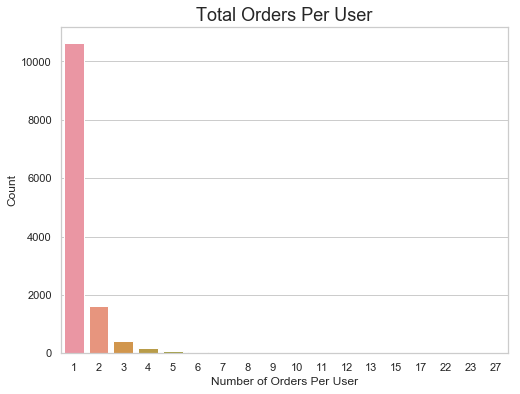

In [462]:
f, ax= plt.subplots(figsize=(8,6))
ax = sns.countplot(x='total_orders', data=u)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Number of Orders Per User')
ax.set_title('Total Orders Per User', fontsize=18)

#### User Value    
A typical user spends $65.00 (median) on the website.

Text(0,0.5,'USD')

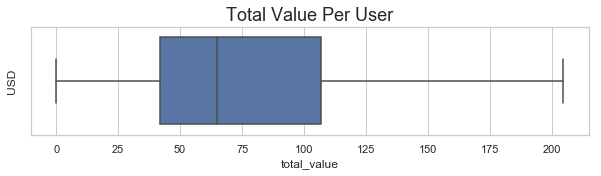

In [473]:
f, ax= plt.subplots(figsize=(10,2))
sns.boxplot(u['total_value'], showfliers=False)
ax.set_title('Total Value Per User', fontsize=18)
ax.set_ylabel('USD', fontsize=12)

In [474]:
u['total_value'].describe()

count    1.309100e+04
mean              inf
std               inf
min      0.000000e+00
25%      4.200000e+01
50%      6.500000e+01
75%      1.070000e+02
max      4.788000e+03
Name: total_value, dtype: float64

#### Basket Size    
64.52% of orders contained only 1 item, 21.87% contained 2 items, 8.29% contained 3 items.

Text(0.5,1,'Basket Size')

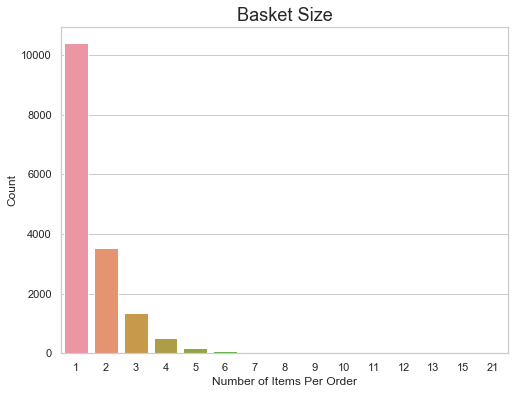

In [461]:
basket_size = baskets['basket_size'].value_counts().reset_index()
f, ax= plt.subplots(figsize=(8,6))
ax = sns.barplot(y=basket_size['basket_size'][:15], x=basket_size['index'][:15])
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Number of Items Per Order')
ax.set_title('Basket Size', fontsize=18)


#### Averge Order Value    
A typical order is $57.41.

Text(0,0.5,'USD')

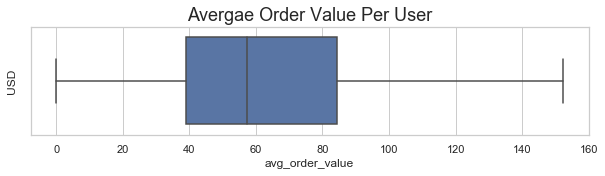

In [475]:
f, ax= plt.subplots(figsize=(10,2))
sns.boxplot(u['avg_order_value'], showfliers=False)
ax.set_title('Avergae Order Value Per User', fontsize=18)
ax.set_ylabel('USD', fontsize=12)

In [476]:
u['avg_order_value'].describe()

count    13091.000000
mean        69.298820
std         48.066101
min          0.000000
25%         39.000000
50%         57.406250
75%         84.437500
max        998.000000
Name: avg_order_value, dtype: float64

#### Top10 Popular Items

Text(0.5,1,'Top10 Popular Items')

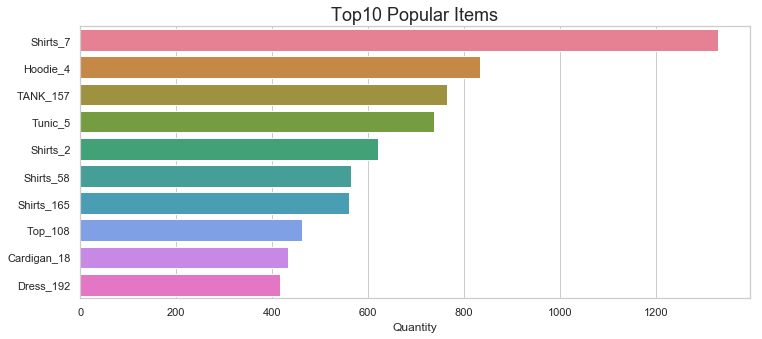

In [428]:
# popular items
top10_items = success_items['product_name'].value_counts()[:10]
f, ax= plt.subplots(figsize=(12,5))
ax = sns.barplot(y=top10_items.index, x=top10_items.values, palette="husl")
ax.set_xlabel('Quantity', fontsize=12)
ax.set_title('Top10 Popular Items', fontsize=18)


## Data Mining
### 1. Does the website traffic have significant influence on the orders?    
Web traffic did have a **significant positive** impact on sales. 
There is a strong (*correlation > 0.7*) and significant (*p < 0.001*) relationship between:
* page_views ~ total_orders    
* page_views ~ total_price    
* product_detail_views ~ total_orders    
* product_detail_views ~ total_price

In [272]:
sales = pd.DataFrame()
sales['total_orders'] = success_orders.groupby('created_at').size().astype(np.int16)
sales['total_price'] = success_orders.groupby('created_at')['total_price'].sum()
sales['total_discounts'] = success_orders.groupby('created_at')['total_discounts'].sum()
sales['discount_ratio'] = sales['total_discounts']/(sales['total_discounts']+sales['total_price'])
sales = sales.reset_index()

sales.rename(columns={'created_at':'date'}, inplace=True)
traffic.rename(columns={'date_day':'date'}, inplace=True)
sales_traffic = sales.merge(traffic, on='date', how='left')
sales_traffic.drop('index', inplace=True, axis=1)

Intuitively, web traffic peaks overlap with sales peaks.

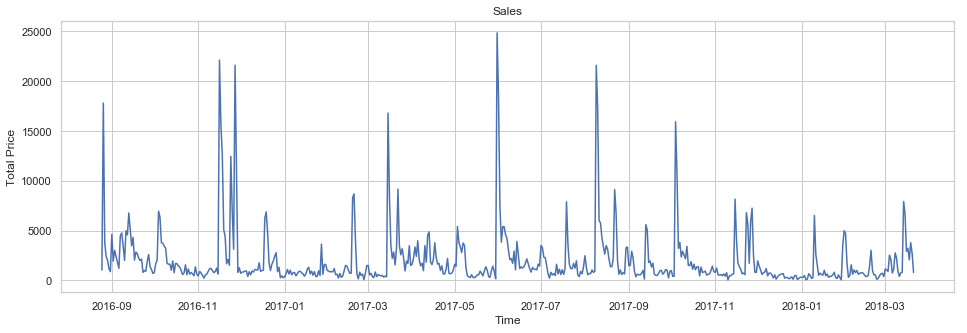

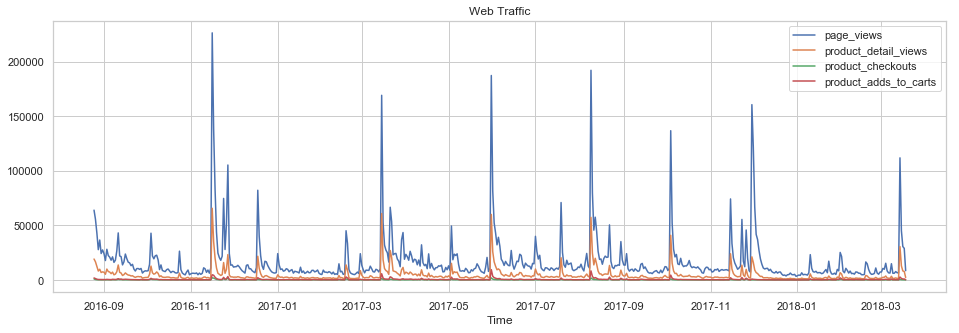

In [464]:
plt.figure(figsize=(16,5))
plt.plot(sales_traffic['date'], sales_traffic['total_price'])
plt.title('Sales')
plt.ylabel('Total Price')
plt.xlabel('Time', fontsize=12)
plt.show()

plt.figure(figsize=(16,5))
plt.plot(sales_traffic['date'], sales_traffic['page_views'], label='page_views')
plt.plot(sales_traffic['date'], sales_traffic['product_detail_views'], label='product_detail_views')
plt.plot(sales_traffic['date'], sales_traffic['product_checkouts'], label='product_checkouts')
plt.plot(sales_traffic['date'], sales_traffic['product_adds_to_carts'], label='product_adds_to_carts')
plt.legend(loc='best')
plt.title('Web Traffic')
plt.xlabel('Time', fontsize=12)
plt.show()

Text(0.5,1,'Spearman Correlation Between Features')

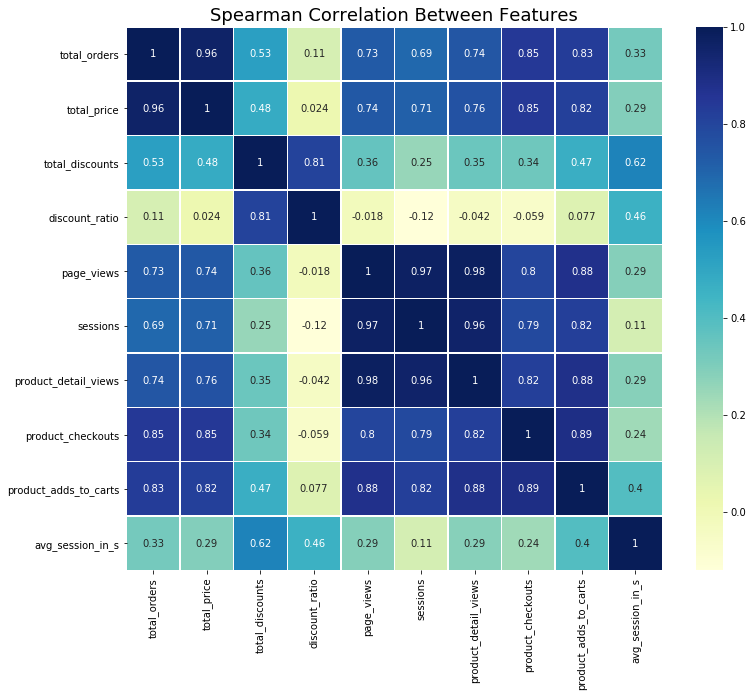

In [392]:
#The variables are not normally distributed (mostly left-skewed), use Spearman correlation instead of Pearson correlation
sales_corr = sales_traffic.iloc[:,1:].dropna(axis=0, how='any', inplace=False).corr(method='spearman')
f, ax= plt.subplots(figsize=(12,10))
sns.heatmap(sales_corr, annot=True, linewidths=.5, cmap="YlGnBu", ax=ax)
ax.set_title('Spearman Correlation Between Features', fontsize=18)

In [396]:
from scipy import stats
tmp = sales_traffic.dropna(axis=0, how='any')

print('page_views ~ total_orders:\n', stats.spearmanr(tmp['page_views'], tmp['total_orders']))
print('page_views ~ total_price:\n', stats.spearmanr(tmp['page_views'], tmp['total_price']))
print('product_detail_views ~ total_orders:\n', stats.spearmanr(tmp['product_detail_views'], tmp['total_orders']))
print('product_detail_views ~ total_price:\n', stats.spearmanr(tmp['product_detail_views'], tmp['total_price']))

page_views ~ total_orders:
 SpearmanrResult(correlation=0.7310387213206743, pvalue=2.3495864284057968e-96)
page_views ~ total_price:
 SpearmanrResult(correlation=0.7402875916027802, pvalue=5.091497607684181e-100)
product_detail_views ~ total_orders:
 SpearmanrResult(correlation=0.7447677347725363, pvalue=7.501223063715746e-102)
product_detail_views ~ total_price:
 SpearmanrResult(correlation=0.7568681821797324, pvalue=5.370132956665842e-107)


### 2. Does the promotion (e.g. discount) used in the datasets promote sales?     
Discounts didn't significantly boost sales. The correlation between discount ratio and total orders/total price is very weak.    
Possible explanation is the discount rates were too low, mostly between 1%-7% off. Users didn't perceive there was a discount, thus they were not motivated.

Text(0.5,1,'Spearman Correlation Between Discount and Sales')

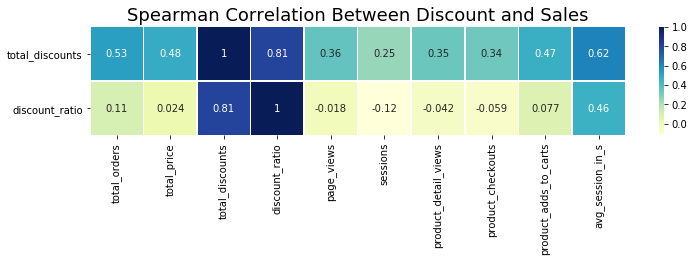

In [402]:
f, ax= plt.subplots(figsize=(12,2))
sns.heatmap(sales_corr.iloc[2:4,:], annot=True, linewidths=.5, cmap="YlGnBu", ax=ax)
ax.set_title('Spearman Correlation Between Discount and Sales', fontsize=18)

Text(0.5,1,'Discount Rate')

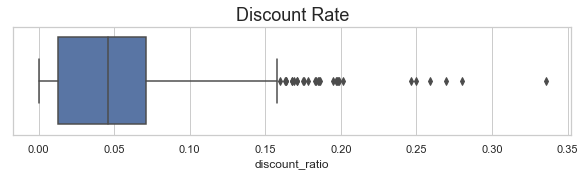

In [472]:
f, ax= plt.subplots(figsize=(10,2))
sns.set(style="whitegrid")
sns.boxplot(sales_traffic['discount_ratio'])
ax.set_title('Discount Rate', fontsize=18)

### 3. Is there any significant correlation between different products?    
Association rules mining using apriori    
    
**Top5 Rules by RPF**    
(rule power factor: rpf(X -> Y) = conf(X -> Y) * supp(X,Y))
1. (Trousers_42) -> (Top_40)    
2. (Shirts_2) -> (Shirts_7)    
3. (Pullover_156) -> (Trousers_16)    
4. (Skirt_38) -> (Top_185)    
5. (Trousers_37) -> (Top_15)    
    
**Top5 Rules by Confidence**    
(conf(X -> Y) = supp(X,Y)/supp(X))
1. (Trousers_122) -> (crop top_120)    
2. (Dress_163, Top_40) -> (Trousers_42)    
3. (Trousers_16, Tunic_5) -> (Pullover_156)    
4. (Skirt_98) -> (Top_82)    
5. (crop top_103) -> (Trousers_206)    

X: antecedent; Y: consequent    
* conf(X -> Y) = supp(X,Y)/supp(X)
* lift(X -> Y) = conf(X -> Y)/supp(Y); lift > 1, X and Y are dependent
* rule power factor: rpf(X -> Y) = conf(X -> Y) * supp(X,Y)

In [244]:
basket_onehot = success_items.groupby(['order_id','product_name'])['quantity'].sum().unstack().reset_index().fillna(0)

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_onehot = basket_onehot.applymap(encode_units)
basket_onehot.drop('order_id', inplace=True, axis=1)

In [254]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(basket_onehot, min_support=10/len(basket_onehot), use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules['rpf'] = rules['confidence']*rules['support']
top_rules = rules[rules['confidence'] >= 0.3]

top_rules_rpf= top_rules.sort_values(by=['rpf','confidence','lift'], ascending=(False,False,False))
top_rules_conf= top_rules.sort_values(by=['confidence','rpf','lift'], ascending=(False,False,False))

In [482]:
top_rules_rpf[:10][['antecedents','consequents','support','confidence','rpf']]

,antecedents,consequents,support,confidence,rpf
381,(Trousers_42),(Top_40),0.008856,0.697561,0.006178
380,(Top_40),(Trousers_42),0.008856,0.434650,0.003849
210,(Shirts_2),(Shirts_7),0.011519,0.315254,0.003631
201,(Pullover_156),(Trousers_16),0.004583,0.435294,0.001995
291,(Skirt_38),(Top_185),0.003344,0.593407,0.001985
290,(Top_185),(Skirt_38),0.003344,0.568421,0.001901
200,(Trousers_16),(Pullover_156),0.004583,0.404372,0.001853
356,(Trousers_37),(Top_15),0.003840,0.410596,0.001577
357,(Top_15),(Trousers_37),0.003840,0.410596,0.001577
301,(Skirt_98),(Top_82),0.002168,0.714286,0.001548


In [484]:
top_rules_conf[:10][['antecedents','consequents','support','confidence','rpf']]

,antecedents,consequents,support,confidence,rpf
390,(Trousers_122),(crop top_120),0.000991,0.842105,0.000834
408,"(Dress_163, Top_40)",(Trousers_42),0.000681,0.785714,0.000535
409,"(Dress_163, Trousers_42)",(Top_40),0.000681,0.785714,0.000535
433,"(Trousers_16, Tunic_5)",(Pullover_156),0.001053,0.772727,0.000814
391,(crop top_120),(Trousers_122),0.000991,0.727273,0.000721
301,(Skirt_98),(Top_82),0.002168,0.714286,0.001548
399,(crop top_103),(Trousers_206),0.001301,0.700000,0.000910
381,(Trousers_42),(Top_40),0.008856,0.697561,0.006178
446,"(Trousers_42, Shorts_55)",(Top_40),0.000743,0.666667,0.000495
348,(Trousers_114),(Top_113),0.001920,0.659574,0.001266


### 4. Suggestions for sales

#### 4.1  Create awareness and interests
The pricing, user size and sales volume suggest the company is probably a fast fashion startup. Given that web traffic has significant impact on sales, it would be good for them to focus on creating awareness by boosting traffic.    
Possible solutions:
- Collaborate with designers to provide exclusive editions    
- Collaborate with influencers/carry out social media campaigns    
- Ads    
    
#### 4.2 Improve website conversion rates    
The funnel shows the conversion rate was 10.5% from product detail views to product adds to cart, 28.2% from product adds to cart to product checkouts. In other words, 1 in 9.5 products viewed were added to the cart, and 1 in 3.5 items added to the cart were checked out. No fatal problems but still space for improvement.    
    
**Improve product detail page**    
- Informative product page would ease decision-making. Check if there are enough images fully display the product, do the images look real, is the description specific and concrete    
- Personalized and non-personalized **recommendation system**. User can shop the suits, compare similar items, or browse other items if this one doesn't fit. Non-personalized recommendations can be provided based on the association rules discovered, popular items and highly-reated items. Personalized recommender can be built with algorithms like collaborative filtering.    
    
**Recover abandoned cart**    
- **Check and remove possible frictions** that prevent checkout, e.g., do they hide shipping and tax until the last step, is the checkout process too complex, are there enough payment options etc.    
- It's common people use cart as favorite list, they add items but are just watching with low purchasing intent. Incentivize them to make the purchase by **ad retargeting** (remarketing the items to the user on different platforms), or sending a follow-up email with **time-limited coupon**.

Text(0.5,1,'Website Conversion Funnel')

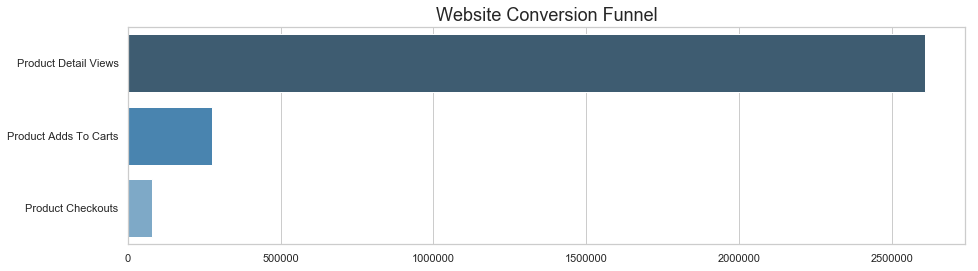

In [421]:
f, ax= plt.subplots(figsize=(15,4))
ax = sns.barplot(y=['Product Detail Views', 'Product Adds To Carts', 'Product Checkouts'],
            x=[sales_traffic['product_detail_views'].sum(), sales_traffic['product_adds_to_carts'].sum(), sales_traffic['product_checkouts'].sum()],
            palette="Blues_d")
ax.set_title('Website Conversion Funnel', fontsize=18)

#### 4.3  Build loyalty    
Customer retention rate was low. Over 80% users made only one purchase.
- Launch or improve current loyalty program    
- Do customer satisfaction research and improve customer experience. e.g., Do customer find what they need/like? Are they satisfied with the product/service? Does the company capture the latest fashion trends?    
    
#### 4.4 Offer discount at larger rate    
    
#### 4.5  Look into previous popular products and try to reproduce the sales and marketing process
Some trend-triggering products that drives sales are:
- `Shirts_7`: had several sales peaks and robustly drove sales during 2016 Thanks Giving holidays (best-seller during 2016-11-24 to 2016-11-28).
- `Sweater_104`: Good timing. The sweater was launched in August 2017 when fall was approaching, and immediately became a popular item, followed by a second sales peak in September.
- `Maxi_239`: among the recently-launched Maxi product line, this item's performing well. As of the data was collected, it has been the best-selling item during 2018-03-14 to 2018-03-15.    
Case study on these product may provide insights on sales and marketing.

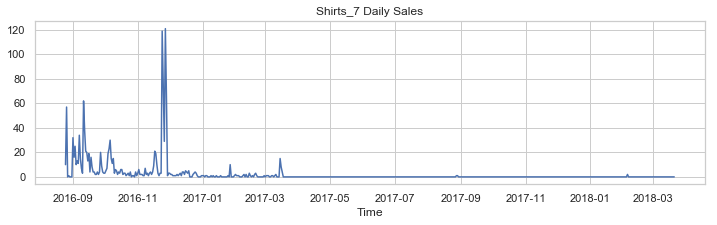

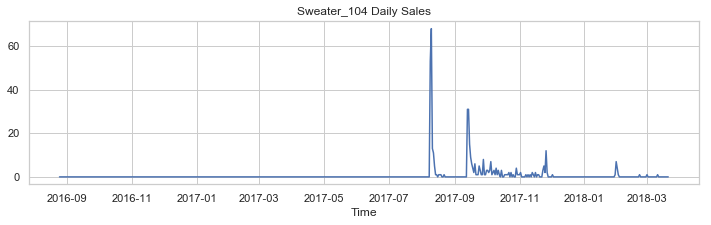

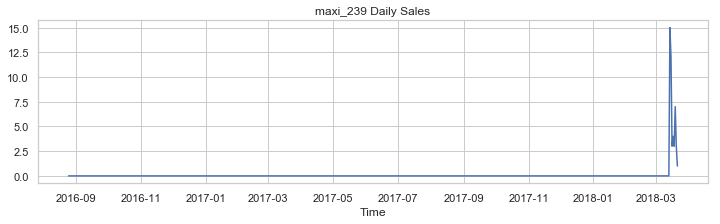

In [412]:
# previous successful products
peak_days = sales_traffic[(sales_traffic['total_price']>=sales_traffic['total_price'].quantile(0.90))|(sales_traffic['total_orders']>=sales_traffic['total_orders'].quantile(0.90))]['date'].tolist()

peak_items = success_orders[success_orders['created_at'].isin(peak_days)][['created_at','order_id']].merge(success_items, on='order_id', how='inner')
pi = peak_items.groupby(['created_at','product_name'])['quantity'].sum().unstack().reset_index().fillna(0)
pi.dropna(axis=1, how='all', inplace=True)
pi = pi.set_index('created_at')

pi_top3 = pd.DataFrame(pi.columns.values[np.argsort(-pi.values, axis=1)[:, :3]], 
                  index=pi.index,
                  columns = ['1st Max','2nd Max','3rd Max']).reset_index()

daily_items = success_orders[['created_at','order_id']].merge(success_items, on='order_id', how='left')
di = daily_items.groupby(['created_at','product_name'])['quantity'].sum().unstack().reset_index().fillna(0)
di = di.set_index('created_at')


plt.figure(figsize=(12,3))
plt.plot(di.index, di['Shirts_7'])
plt.title('Shirts_7 Daily Sales')
plt.xlabel('Time', fontsize=12)

plt.figure(figsize=(12,3))
plt.plot(di.index, di['Sweater_104'])
plt.title('Sweater_104 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(di.index, di['maxi_239'])
plt.title('maxi_239 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()

Text(0.5,0,'Time')

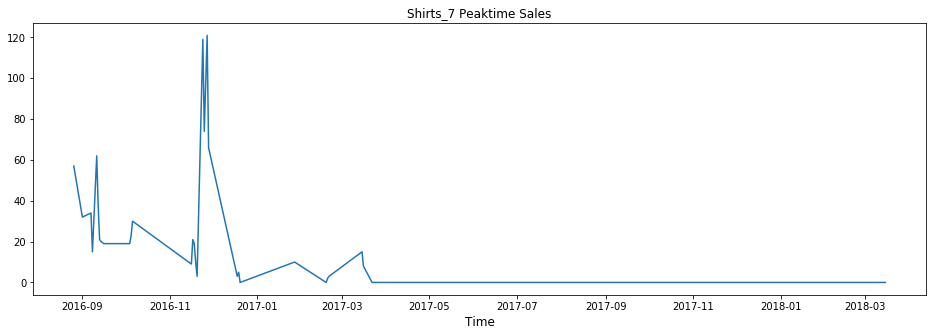

In [337]:
plt.figure(figsize=(16,5))
plt.plot(pi.index, pi['Shirts_7'])
plt.title('Shirts_7 Peaktime Sales')
plt.xlabel('Time', fontsize=12)

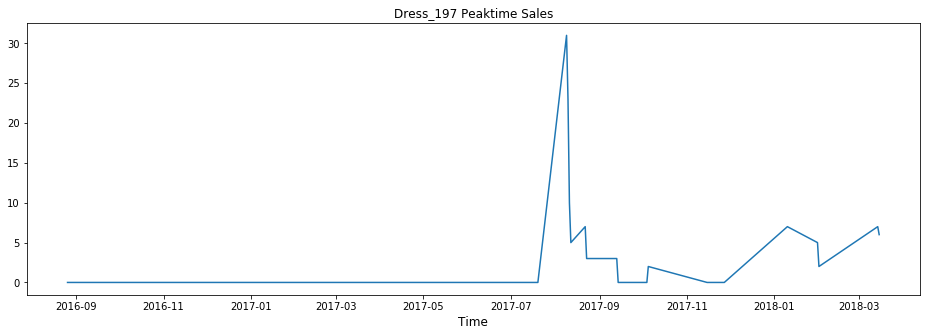

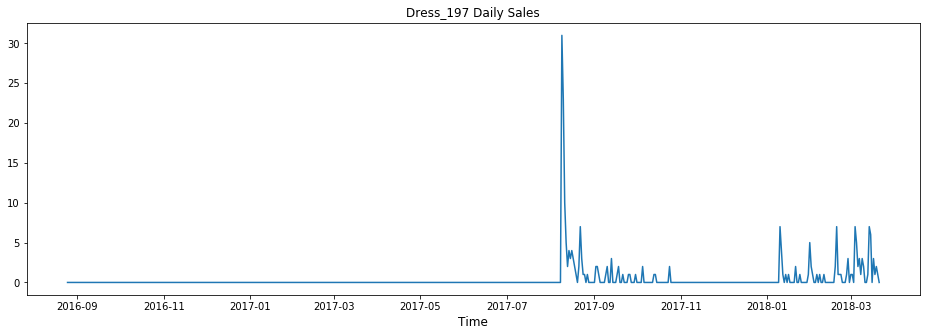

In [344]:
plt.figure(figsize=(16,5))
plt.plot(pi.index, pi['Dress_197'])
plt.title('Dress_197 Peaktime Sales')
plt.xlabel('Time', fontsize=12)
plt.show()
plt.figure(figsize=(16,5))
plt.plot(di.index, di['Dress_197'])
plt.title('Dress_197 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()


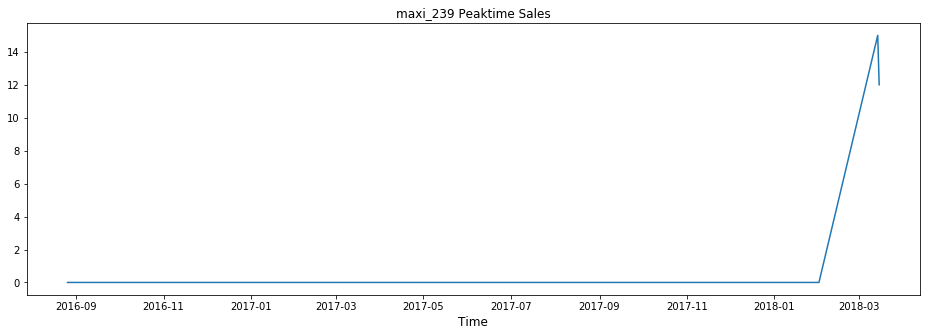

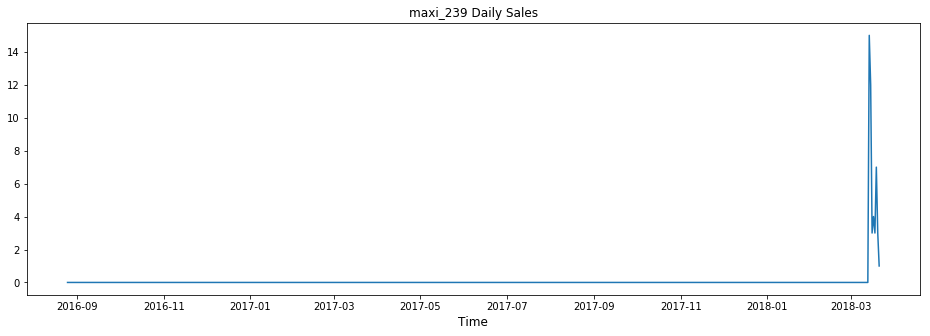

In [345]:
plt.figure(figsize=(16,5))
plt.plot(pi.index, pi['maxi_239'])
plt.title('maxi_239 Peaktime Sales')
plt.xlabel('Time', fontsize=12)
plt.show()
plt.figure(figsize=(16,5))
plt.plot(di.index, di['maxi_239'])
plt.title('maxi_239 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()


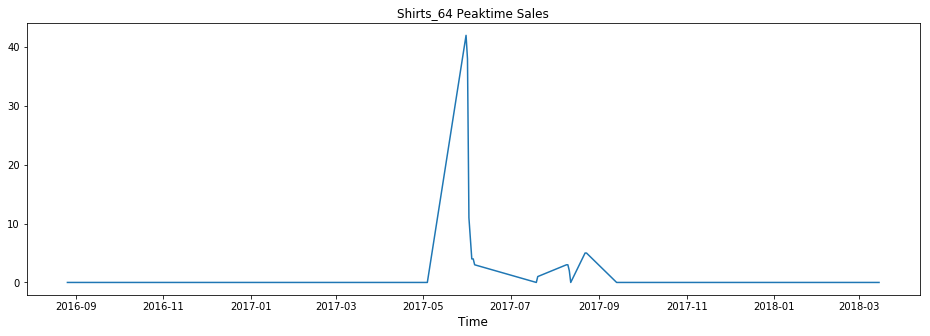

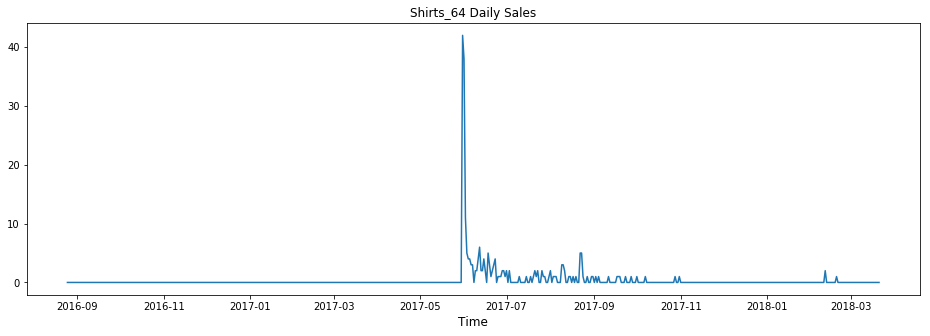

In [349]:
plt.figure(figsize=(16,5))
plt.plot(pi.index, pi['Shirts_64'])
plt.title('Shirts_64 Peaktime Sales')
plt.xlabel('Time', fontsize=12)
plt.show()
plt.figure(figsize=(16,5))
plt.plot(di.index, di['Shirts_64'])
plt.title('Shirts_64 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()

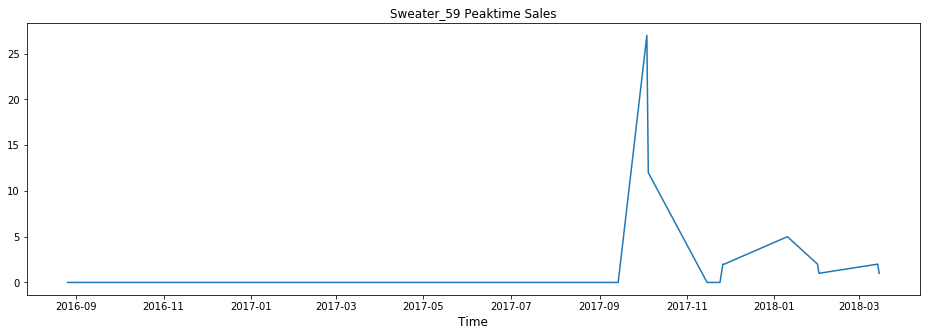

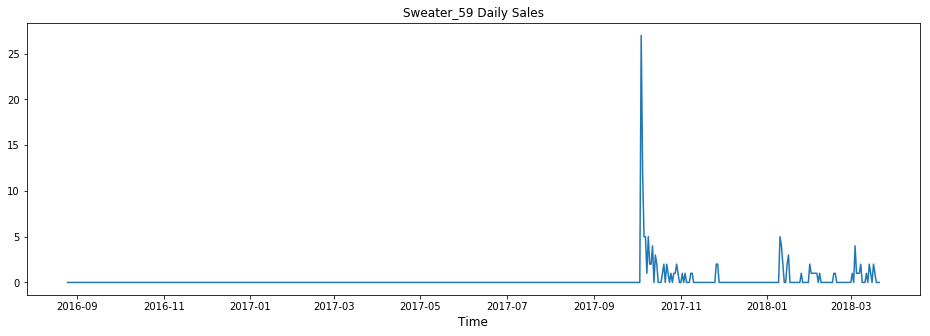

In [350]:
plt.figure(figsize=(16,5))
plt.plot(pi.index, pi['Sweater_59'])
plt.title('Sweater_59 Peaktime Sales')
plt.xlabel('Time', fontsize=12)
plt.show()
plt.figure(figsize=(16,5))
plt.plot(di.index, di['Sweater_59'])
plt.title('Sweater_59 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()


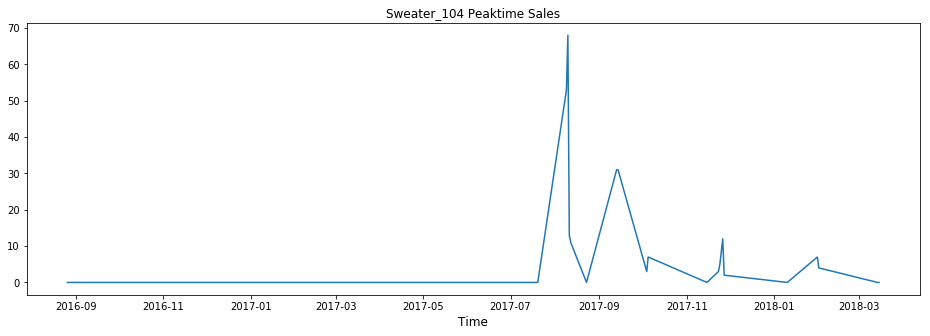

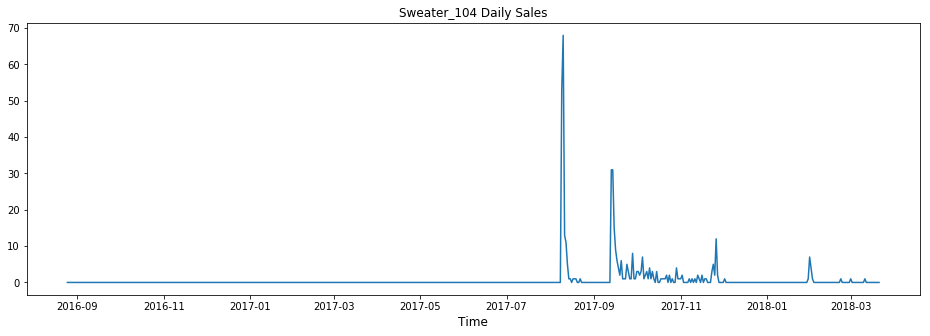

In [351]:
plt.figure(figsize=(16,5))
plt.plot(pi.index, pi['Sweater_104'])
plt.title('Sweater_104 Peaktime Sales')
plt.xlabel('Time', fontsize=12)
plt.show()
plt.figure(figsize=(16,5))
plt.plot(di.index, di['Sweater_104'])
plt.title('Sweater_104 Daily Sales')
plt.xlabel('Time', fontsize=12)
plt.show()


In [327]:
pi_top3

,created_at,1st Max,2nd Max,3rd Max
0,2016-08-26,Tunic_5,Shirts_2,Hoodie_4
1,2016-09-01,Shirts_7,Hoodie_4,Tunic_5
2,2016-09-07,Shirts_7,Hoodie_4,Tunic_5
3,2016-09-08,Tunic_5,Shirts_7,Trousers_24
4,2016-09-11,Shirts_7,Shirts_2,Hoodie_4
5,2016-09-12,Shirts_7,Shirts_2,Tunic_5
6,2016-09-13,Cardigan_18,Shirts_7,Shirts_2
7,2016-09-14,Cardigan_18,Shirts_7,Hoodie_4
8,2016-09-16,Shirts_7,Shirts_2,Hoodie_4
9,2016-10-04,Hoodie_4,Cardigan_18,Shirts_7


In [348]:
sales_traffic[sales_traffic['date'].isin(peak_days)][['date','total_price']]

,date,total_price
1,2016-08-26,17804.98
7,2016-09-01,4629.29
13,2016-09-07,4471.41
14,2016-09-08,4765.63
17,2016-09-11,4979.57
18,2016-09-12,4567.40
19,2016-09-13,6768.87
20,2016-09-14,5105.48
22,2016-09-16,4312.02
40,2016-10-04,6946.72


import pyfpgrowth

patterns = pyfpgrowth.find_frequent_patterns(baskets['item_name'], 10)
rules = pyfpgrowth.generate_association_rules(patterns,0.3)

def calc_supp(x, baskets):
    cnt = 0
    for b in baskets:
        if set(x).issubset(set(b)):
            cnt += 1
    return cnt



rules_df = pd.DataFrame()
rules_df['X'] = rules.keys()
rules_df['Y'] = rules.values()
rules_df['confidence'] = rules_df['Y'].map(lambda x: x[1])
rules_df['Y'] = rules_df['Y'].map(lambda x: x[0])
rules_df['supp(Y)'] = rules_df['Y'].map(lambda x: calc_supp(x, baskets['item_name']))
rules_df['supp(Y)'] = rules_df['supp(Y)']/len(baskets)
rules_df['supp(X)'] = rules_df['X'].map(lambda x: calc_supp(x, baskets['item_name']))
rules_df['supp(X)'] = rules_df['supp(X)']/len(baskets)
rules_df['supp(X,Y)'] = rules_df['confidence']*rules_df['supp(X)']
rules_df['lift'] = rules_df['confidence']/rules_df['supp(Y)']
rules_df['rpf'] = rules_df['confidence']*rules_df['supp(X,Y)']

rules_df.sort_values(by=['rpf','confidence','lift'], ascending=(False,False,False))[['X','Y','rpf','confidence','lift']]


top_rules_df = rules_df[(rules_df['lift'] > 1)&(rules_df['confidence']>=0.5)].sort_values(by=['rpf','confidence','lift'], ascending=(False,False,False))
top_rules_df[['X','Y','rpf','confidence','lift']]


In [291]:
discount_sales = sales_traffic[sales_traffic['total_discounts']>0]

In [294]:
discount_corr = discount_sales.iloc[:,1:].corr()

In [295]:
discount_corr

,total_orders,total_price,total_discounts,discount_ratio,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_in_s
total_orders,1.000000,0.939330,0.756809,0.080482,0.712821,0.640239,0.729400,0.868841,0.767911,0.315885
total_price,0.939330,1.000000,0.647938,-0.014367,0.818211,0.729711,0.857903,0.900668,0.895989,0.347918
total_discounts,0.756809,0.647938,1.000000,0.428234,0.392357,0.329500,0.390285,0.560166,0.449664,0.296353
discount_ratio,0.080482,-0.014367,0.428234,1.000000,-0.106936,-0.127015,-0.115836,0.015003,-0.057337,0.152007
page_views,0.712821,0.818211,0.392357,-0.106936,1.000000,0.976189,0.957564,0.821351,0.890448,0.242320
sessions,0.640239,0.729711,0.329500,-0.127015,0.976189,1.000000,0.889808,0.730647,0.789251,0.127059
product_detail_views,0.729400,0.857903,0.390285,-0.115836,0.957564,0.889808,1.000000,0.843892,0.952699,0.289710
product_checkouts,0.868841,0.900668,0.560166,0.015003,0.821351,0.730647,0.843892,1.000000,0.910444,0.381897
product_adds_to_carts,0.767911,0.895989,0.449664,-0.057337,0.890448,0.789251,0.952699,0.910444,1.000000,0.377447
avg_session_in_s,0.315885,0.347918,0.296353,0.152007,0.242320,0.127059,0.289710,0.381897,0.377447,1.000000


In [296]:
discount_1 = sales_traffic[sales_traffic['discount_ratio']>0.01]
print(len(discount_1))
discount_1.iloc[:,1:].corr()

433


,total_orders,total_price,total_discounts,discount_ratio,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_in_s
total_orders,1.000000,0.934356,0.815825,0.131257,0.688197,0.606218,0.715092,0.856159,0.752949,0.355524
total_price,0.934356,1.000000,0.700391,0.031115,0.800630,0.700245,0.850668,0.892329,0.890067,0.392489
total_discounts,0.815825,0.700391,1.000000,0.425903,0.428748,0.369841,0.417442,0.636220,0.477739,0.292420
discount_ratio,0.131257,0.031115,0.425903,1.000000,-0.069724,-0.085524,-0.085288,0.077157,-0.024684,0.132930
page_views,0.688197,0.800630,0.428748,-0.069724,1.000000,0.974381,0.954730,0.803085,0.881330,0.280849
sessions,0.606218,0.700245,0.369841,-0.085524,0.974381,1.000000,0.881189,0.693332,0.771077,0.165191
product_detail_views,0.715092,0.850668,0.417442,-0.085288,0.954730,0.881189,1.000000,0.842159,0.949553,0.323341
product_checkouts,0.856159,0.892329,0.636220,0.077157,0.803085,0.693332,0.842159,1.000000,0.915406,0.450988
product_adds_to_carts,0.752949,0.890067,0.477739,-0.024684,0.881330,0.771077,0.949553,0.915406,1.000000,0.412184
avg_session_in_s,0.355524,0.392489,0.292420,0.132930,0.280849,0.165191,0.323341,0.450988,0.412184,1.000000


In [298]:
discount_5 = sales_traffic[sales_traffic['discount_ratio']>0.05]
print(len(discount_5))
discount_5.iloc[:,1:].corr()

265


,total_orders,total_price,total_discounts,discount_ratio,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_in_s
total_orders,1.000000,0.933188,0.848144,0.088686,0.648815,0.571935,0.676311,0.839611,0.732845,0.304819
total_price,0.933188,1.000000,0.736024,-0.022044,0.775045,0.680412,0.838650,0.867779,0.875858,0.347433
total_discounts,0.848144,0.736024,1.000000,0.374138,0.438749,0.378609,0.441406,0.653947,0.496947,0.251925
discount_ratio,0.088686,-0.022044,0.374138,1.000000,-0.124988,-0.134212,-0.138989,0.046467,-0.079180,0.044535
page_views,0.648815,0.775045,0.438749,-0.124988,1.000000,0.977821,0.958786,0.764481,0.871749,0.244849
sessions,0.571935,0.680412,0.378609,-0.134212,0.977821,1.000000,0.895607,0.656808,0.770982,0.128491
product_detail_views,0.676311,0.838650,0.441406,-0.138989,0.958786,0.895607,1.000000,0.803564,0.945394,0.281494
product_checkouts,0.839611,0.867779,0.653947,0.046467,0.764481,0.656808,0.803564,1.000000,0.896701,0.438542
product_adds_to_carts,0.732845,0.875858,0.496947,-0.079180,0.871749,0.770982,0.945394,0.896701,1.000000,0.394664
avg_session_in_s,0.304819,0.347433,0.251925,0.044535,0.244849,0.128491,0.281494,0.438542,0.394664,1.000000


In [299]:
discount_10 = sales_traffic[sales_traffic['discount_ratio']>0.1]
print(len(discount_10))
discount_10.iloc[:,1:].corr()

74


,total_orders,total_price,total_discounts,discount_ratio,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_in_s
total_orders,1.000000,0.985101,0.883658,0.096496,0.870201,0.863585,0.824228,0.795820,0.753740,0.187596
total_price,0.985101,1.000000,0.882557,0.081095,0.888518,0.864911,0.851244,0.840933,0.798009,0.230077
total_discounts,0.883658,0.882557,1.000000,0.316000,0.674487,0.663558,0.633953,0.631390,0.587550,0.189736
discount_ratio,0.096496,0.081095,0.316000,1.000000,-0.022353,-0.044057,-0.023452,0.020432,-0.006124,0.041721
page_views,0.870201,0.888518,0.674487,-0.022353,1.000000,0.971136,0.979002,0.946535,0.916156,0.262687
sessions,0.863585,0.864911,0.663558,-0.044057,0.971136,1.000000,0.955976,0.855789,0.850426,0.084546
product_detail_views,0.824228,0.851244,0.633953,-0.023452,0.979002,0.955976,1.000000,0.940487,0.947087,0.265664
product_checkouts,0.795820,0.840933,0.631390,0.020432,0.946535,0.855789,0.940487,1.000000,0.964155,0.435452
product_adds_to_carts,0.753740,0.798009,0.587550,-0.006124,0.916156,0.850426,0.947087,0.964155,1.000000,0.415320
avg_session_in_s,0.187596,0.230077,0.189736,0.041721,0.262687,0.084546,0.265664,0.435452,0.415320,1.000000


In [300]:
discount_20 = sales_traffic[sales_traffic['discount_ratio']>0.2]
print(len(discount_20))
discount_20.iloc[:,1:].corr()

7


,total_orders,total_price,total_discounts,discount_ratio,page_views,sessions,product_detail_views,product_checkouts,product_adds_to_carts,avg_session_in_s
total_orders,1.000000,0.999337,0.998316,0.169170,0.916243,0.953212,0.705711,0.301928,0.221268,-0.569824
total_price,0.999337,1.000000,0.999614,0.187916,0.909716,0.949660,0.691651,0.294523,0.216801,-0.586604
total_discounts,0.998316,0.999614,1.000000,0.209259,0.901013,0.943430,0.676306,0.279501,0.205536,-0.597298
discount_ratio,0.169170,0.187916,0.209259,1.000000,0.026887,0.049828,-0.147979,0.041086,0.198142,-0.032361
page_views,0.916243,0.909716,0.901013,0.026887,1.000000,0.990364,0.927710,0.615762,0.533400,-0.309202
sessions,0.953212,0.949660,0.943430,0.049828,0.990364,1.000000,0.873737,0.517421,0.432754,-0.434865
product_detail_views,0.705711,0.691651,0.676306,-0.147979,0.927710,0.873737,1.000000,0.787762,0.711399,-0.001671
product_checkouts,0.301928,0.294523,0.279501,0.041086,0.615762,0.517421,0.787762,1.000000,0.958909,0.402603
product_adds_to_carts,0.221268,0.216801,0.205536,0.198142,0.533400,0.432754,0.711399,0.958909,1.000000,0.499258
avg_session_in_s,-0.569824,-0.586604,-0.597298,-0.032361,-0.309202,-0.434865,-0.001671,0.402603,0.499258,1.000000
